# SMART LIVE CAMERA NOTEBOOK

## Necessary modules

In [9]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
from PIL import Image
import glob

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [14]:
last_percent_reported = None
num_classes = 10

np.random.seed(42)

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  downloaded = False
  if force or not os.path.exists(FOLDER + filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(URL + filename, FOLDER + filename, reporthook=download_progress_hook)
    downloaded = True
    print('\nDownload Complete!')
  if downloaded:
    statinfo = os.stat(filename)
  else:
    statinfo = os.stat(FOLDER + filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  if downloaded:
    return filename
  else:
    return FOLDER + filename

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    # Extract tar in the folder where it is placed
    sr = root.split('/')
    sr1 = root.split('/')[0:len(sr)-1]
    sr2 = "/".join(sr1)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(sr2)
    tar.close()
    print('Completed!')
  data_folders = root
  print(data_folders)
  return data_folders

### Eval Functions

In [10]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def pred_acc(predictions, labels):
  return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

def check_predictions(original, labels, predictions):
  print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
  for i, sample in enumerate(original):
    sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    l_ele = labels[i]
    p_ele = predictions[i]
    print('Label %s - Prediction %s' % (l_ele[l_ele != 10], p_ele[p_ele != 10]))
    if (i == 10):
      break
      
def check_rtp_predictions(original, labels, predictions, initial_images):
  print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
  for i, sample in enumerate(original):
    display(Image.open(initial_images[i]))
    sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    l_ele = labels[i]
    p_ele = predictions[i]
    print('Label %s - Prediction %s' % (l_ele[l_ele != 10], p_ele[p_ele != 10]))
    if (i == 10):
      break

## 4. STEP FOUR: SVHN SEQUENCES

### Downloading data

In [1]:
URL = 'http://ufldl.stanford.edu/housenumbers/'
FOLDER = '../data/SVHN_data/'
TRAIN_FILENAME= 'train.tar.gz'
TEST_FILENAME = 'test.tar.gz'
EXTRA_FILENAME = 'extra.tar.gz'

train_filename = maybe_download(TRAIN_FILENAME, 404141560)
test_filename = maybe_download(TEST_FILENAME, 276555967)
extra_filename = maybe_download(EXTRA_FILENAME, 1955489752) 

NameError: name 'maybe_download' is not defined

### Extracting 

In [76]:
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

train_folder = train_folder+'/'
test_folder = test_folder+'/'
extra_folder = extra_folder+'/'

../data/SVHN_data/train already present - Skipping extraction of ../data/SVHN_data/train.tar.gz.
../data/SVHN_data/train
../data/SVHN_data/test already present - Skipping extraction of ../data/SVHN_data/test.tar.gz.
../data/SVHN_data/test
Extracting data for ../data/SVHN_data/extra. This may take a while. Please wait.
Completed!
../data/SVHN_data/extra


#### Check

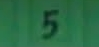

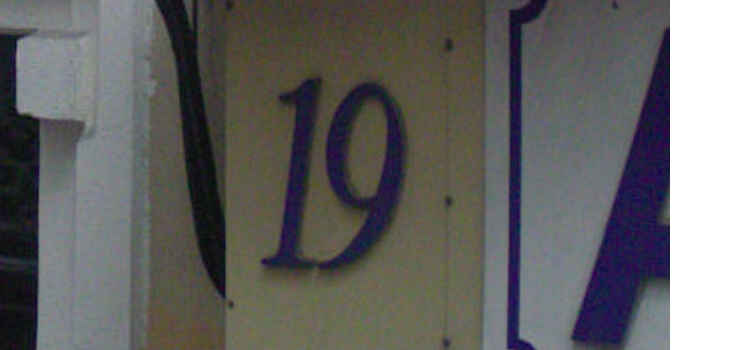

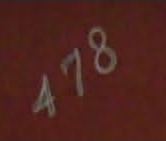

In [78]:
sample = test_folder+'1.png'
display(Image.open(sample))

sample = train_folder+'1.png'
display(Image.open(sample))

sample = extra_folder+'1.png'
display(Image.open(sample))

### Defining preprocessing functions

In [15]:
N = 5
IMAGE_SIZE = 32

def label_zero(labels):
  for label in labels:
    #print(label)
    L = label[0]
    for i in range(1,L+1):
      if label[i] == 10:
        label[i] = 0
          
  return labels

def get_metadata(filename):
  f = h5py.File(filename)
  
  metadata= {}
  metadata['height'] = []
  metadata['label'] = []
  metadata['left'] = []
  metadata['top'] = []
  metadata['width'] = []
  
  def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
    metadata[name].append(vals)
  
  for item in f['/digitStruct/bbox']:
      f[item[0]].visititems(print_attrs)
  return metadata

def image_processing(image, metadata):
  original = Image.open(image)
  L = len(metadata['label'])
  aux = []
  for i in range(L):
    left = metadata['left'][i]
    top = metadata['top'][i]
    right = metadata['left'][i] + metadata['width'][i]
    bottom = metadata['top'][i] + metadata['height'][i]
    cropped = original.crop((left, top, right, bottom)) # crop with bbox data
    pix = np.array(cropped)
    pix_resized = imresize(pix, (IMAGE_SIZE,IMAGE_SIZE)) # resize each digit  
    pix_gs = np.dot(pix_resized[...,:3], [0.299, 0.587, 0.114]) # grayscale
    aux.append(pix_gs)

  sequence = np.hstack(aux) # horizontal stack 
  sequence_resized = imresize(sequence, (IMAGE_SIZE,IMAGE_SIZE)) # resize 
  sequence_resized = sequence_resized.reshape((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32) # 1 channel
  return sequence_resized

def label_processing(metadata):
  L = len(metadata['label'])
  seq_labels = np.ones([N+1], dtype=int) * 10 
  seq_labels[0] = L # labels[i][0] = L to help the loss function. 6xLinearModels: s0...s5 and L 
  for i in range(1,L+1):
    seq_labels[i] = metadata['label'][i-1]
  return seq_labels

In [80]:
N = 5
IMAGE_SIZE = 32
NUM_CHANNELS = 1

def data_processing(folder):
  print('Processing %s' % folder)
  images = glob.glob(folder+'*.png')
  length = len(images)

  dataset = np.ndarray([length,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS], dtype='float32')
  labels = np.ndarray([length, N+1], dtype=int) 
  
  print('Getting Metadata')
  all_metadata = get_metadata(folder+'digitStruct.mat')
  
  print('Processing Images and Labels')
  images = glob.glob(folder+'*.png')
  for image in images:
    sr = os.path.splitext(image)[0]
    sr = sr.split('/')
    sr1 = sr[len(sr)-1]
    i = int(sr1)-1
    metadata = {}
    metadata['label'] = np.array(all_metadata['label'][i]).astype(int)
    metadata['height'] = np.array(all_metadata['height'][i]).astype(int)
    metadata['width'] = np.array(all_metadata['width'][i]).astype(int)
    metadata['top'] = np.array(all_metadata['top'][i]).astype(int)
    metadata['left'] = np.array(all_metadata['left'][i]).astype(int)
    L = len(metadata['label'])
    if L <= N:
      sequence = image_processing(image, metadata)
      seq_labels = label_processing(metadata)
      dataset[i] = sequence
      labels[i] = seq_labels

  return dataset, labels

train_dataset, train_labels = data_processing(train_folder)
test_dataset, test_labels = data_processing(test_folder)
extra_dataset, extra_labels = data_processing(extra_folder)


print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  
print('Extra set', extra_dataset.shape, extra_labels.shape)

Processing ../data/SVHN_data/train/
Getting Metadata
Processing Images and Labels
Processing ../data/SVHN_data/test/
Getting Metadata
Processing Images and Labels
Processing ../data/SVHN_data/extra/
Getting Metadata
Processing Images and Labels
Training set (33402, 32, 32, 1) (33402, 6)
Test set (13068, 32, 32, 1) (13068, 6)
Extra set (202353, 32, 32, 1) (202353, 6)


In [33]:
pickle_file = '../data/SVHN_data/aux.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  extra_dataset = save['extra_dataset']
  extra_labels = save['extra_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)
  print('Extra set', extra_dataset.shape, extra_labels.shape)

Training set (33402, 32, 32, 1) (33402, 6)
Test set (13068, 32, 32, 1) (13068, 6)
Extra set (202353, 32, 32, 1) (202353, 6)


### Check

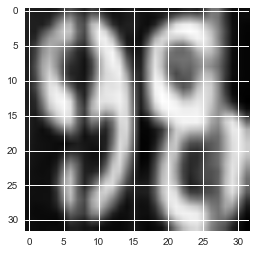

[ 2  9  8 10 10 10]


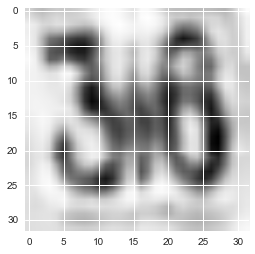

[ 2  3  6 10 10 10]


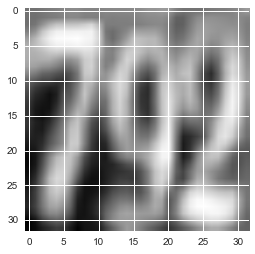

[ 3  7  9  2 10 10]


In [34]:
rd = 131
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])

rd = 131
sample = test_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(test_labels[rd])

rd = 131
sample = extra_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(extra_labels[rd])

### Reformating

In [35]:
VALIDATION_SIZE = 30000
TEST_SIZE_ADD = 45000

valid_dataset = extra_dataset[:VALIDATION_SIZE, ...]
valid_labels = extra_labels[:VALIDATION_SIZE]
extra_dataset = extra_dataset[VALIDATION_SIZE:, ...]
extra_labels = extra_labels[VALIDATION_SIZE:]

test_dataset = np.concatenate((extra_dataset[:TEST_SIZE_ADD, ...], test_dataset), axis=0)
test_labels = np.concatenate((extra_labels[:TEST_SIZE_ADD], test_labels), axis=0)
extra_dataset = extra_dataset[TEST_SIZE_ADD:, ...]
extra_labels = extra_labels[TEST_SIZE_ADD:]

train_dataset = np.concatenate((extra_dataset, train_dataset), axis=0)
train_labels = np.concatenate((extra_labels, train_labels), axis=0)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (160755, 32, 32, 1) (160755, 6)
Test set (58068, 32, 32, 1) (58068, 6)
Validation set (30000, 32, 32, 1) (30000, 6)


#### CHECK 

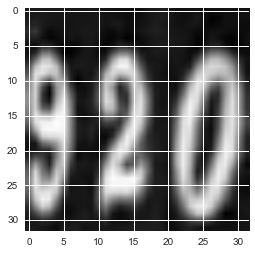

[ 3  9  2 10 10 10]


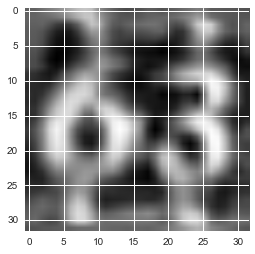

[ 2  6  3 10 10 10]


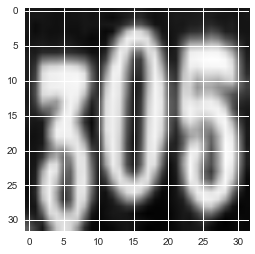

[ 3  3 10  5 10 10]


In [37]:
rd = 1540
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])

rd = 1540
sample = test_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(test_labels[rd])

rd = 1540
sample = valid_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(valid_labels[rd])

In [44]:
train_labels = label_zero(train_labels)
test_labels = label_zero(test_labels)
valid_labels = label_zero(valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (160755, 32, 32, 1) (160755, 6)
Test set (58068, 32, 32, 1) (58068, 6)
Validation set (30000, 32, 32, 1) (30000, 6)


### Check

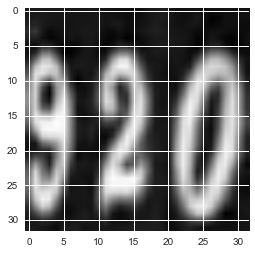

[ 3  9  2  0 10 10]


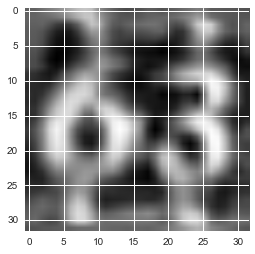

[ 2  6  3 10 10 10]


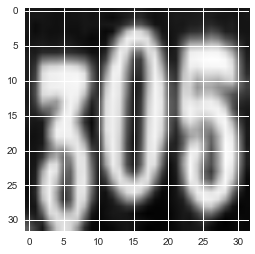

[ 3  3  0  5 10 10]


In [45]:
rd = 1540
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])

rd = 1540
sample = test_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(test_labels[rd])

rd = 1540
sample = valid_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(valid_labels[rd])

#### Save data

In [46]:
pickle_file = '../data/SVHN_data/SVHN-seq.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031122968


#### Load data

In [11]:
pickle_file = '../data/SVHN_data/SVHN-seq.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (160755, 32, 32, 1) (160755, 6)
Validation set (30000, 32, 32, 1) (30000, 6)
Test set (58068, 32, 32, 1) (58068, 6)


#### CHECK

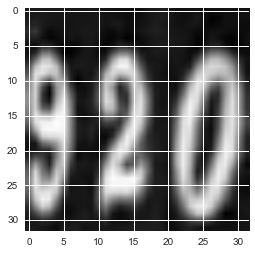

[ 3  9  2  0 10 10]


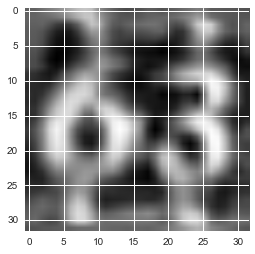

[ 2  6  3 10 10 10]


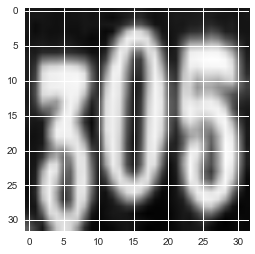

[ 3  3  0  5 10 10]


In [7]:
rd = 1540
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])

rd = 1540
sample = test_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(test_labels[rd])

rd = 1540
sample = valid_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(valid_labels[rd])

### ConvNet 3L - Fully Connected - No Reg - AdaOptimizer 

In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
HIDDEN_NODES = 256

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N+1))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  NL_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_L = tf.nn.bias_add(tf.matmul(reshape, NL_weights), NL_biases)
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5  
  
  logits_L, logits_1, logits_2, logits_3, logits_4, logits_5 = model(tf_train_dataset)
  
  lL = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_L, tf_train_labels[:,0]))
  l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, tf_train_labels[:,1]))
  l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, tf_train_labels[:,2]))
  l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, tf_train_labels[:,3]))
  l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, tf_train_labels[:,4]))
  l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, tf_train_labels[:,5]))
  
  loss = lL+l1+l2+l3+l4+l5
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([
                      tf.nn.softmax(model(tf_train_dataset)[0]),\
                      tf.nn.softmax(model(tf_train_dataset)[1]),\
                      tf.nn.softmax(model(tf_train_dataset)[2]),\
                      tf.nn.softmax(model(tf_train_dataset)[3]),\
                      tf.nn.softmax(model(tf_train_dataset)[4]),\
                      tf.nn.softmax(model(tf_train_dataset)[5])])
  valid_prediction = tf.pack([
                      tf.nn.softmax(model(tf_valid_dataset)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset)[4]),\
                      tf.nn.softmax(model(tf_valid_dataset)[5])])
  test_prediction = tf.pack([
                      tf.nn.softmax(model(tf_test_dataset)[0]),\
                      tf.nn.softmax(model(tf_test_dataset)[1]),\
                      tf.nn.softmax(model(tf_test_dataset)[2]),\
                      tf.nn.softmax(model(tf_test_dataset)[3]),\
                      tf.nn.softmax(model(tf_test_dataset)[4]),\
                      tf.nn.softmax(model(tf_test_dataset)[5])])
  
  saver = tf.train.Saver()

  
NUM_STEPS = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  #sp = saver.restore(session, "../tmp/SVHN-CNN-sequence-L2.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):    
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  #sp = saver.save(session, "../tmp/SVHN-CNN-sequence-L2.ckpt")
  print('Model Saved')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Model Restored
Initialized
Minibatch loss at step 0: 15.046366
Minibatch accuracy: 3.9%
Validation accuracy: 38.7%


### Let's make some preds

Model Restored
Initialized
Accuracy: 97.7%


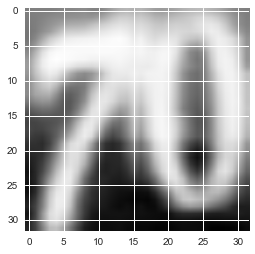

Label [2 7 0] - Prediction [2 7 0]


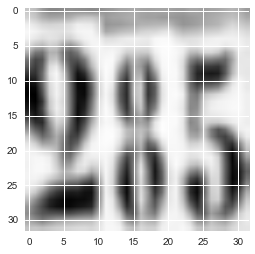

Label [3 2 8 5] - Prediction [3 2 8 5]


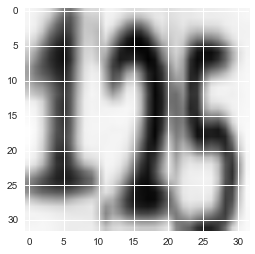

Label [3 1 2 5] - Prediction [3 1 2 5]


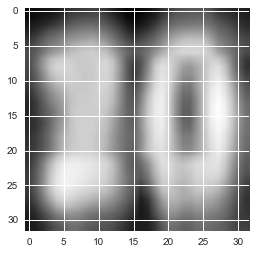

Label [2 2 0] - Prediction [2 2 0]


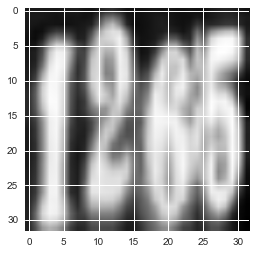

Label [4 1 2 6 5] - Prediction [4 1 2 6 6]


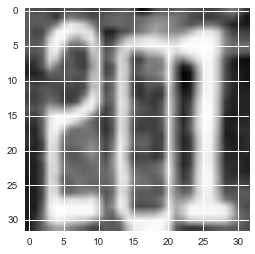

Label [3 2 0 1] - Prediction [3 2 0 1]


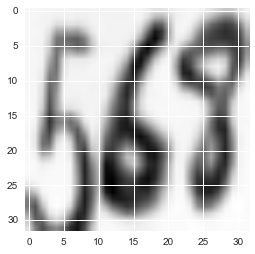

Label [3 5 6 8] - Prediction [3 6 6 1]


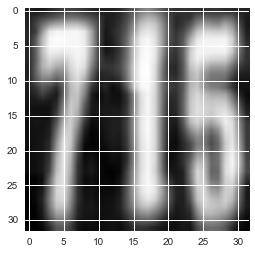

Label [3 7 1 5] - Prediction [3 7 1 5]


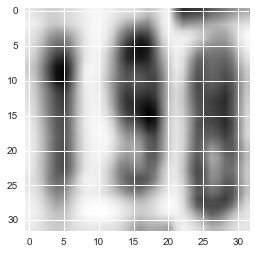

Label [3 1 9 8] - Prediction [3 1 9 8]


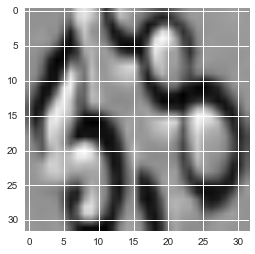

Label [2 3 8] - Prediction [2 6 6]


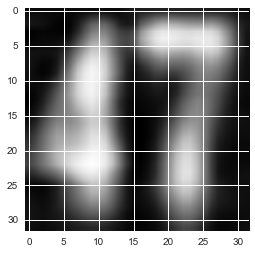

Label [2 4 7] - Prediction [2 4 7]


In [12]:
SAMPLES = 64

IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
HIDDEN_NODES = 256

graph = tf.Graph()

with graph.as_default():
  
  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(SAMPLES, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  NL_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_L = tf.nn.bias_add(tf.matmul(reshape, NL_weights), NL_biases)
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5  
    
  predictions = tf.pack([
                      tf.nn.softmax(model(tf_test_dataset)[0]),\
                      tf.nn.softmax(model(tf_test_dataset)[1]),\
                      tf.nn.softmax(model(tf_test_dataset)[2]),\
                      tf.nn.softmax(model(tf_test_dataset)[3]),\
                      tf.nn.softmax(model(tf_test_dataset)[4]),\
                      tf.nn.softmax(model(tf_test_dataset)[5])])
  
  test_predictions = tf.transpose(tf.argmax(predictions, 2))
  
  saver = tf.train.Saver()    
  
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "../tmp/model-gcp-200k.ckpt")
  print('Model Restored')
  print('Initialized')
  offset = random.randint(0, test_dataset.shape[0]-SAMPLES)
  test_samples = test_dataset[offset:offset+SAMPLES]
  test_samples_labels = test_labels[offset:offset+SAMPLES]
  test_predictions = session.run(test_predictions, feed_dict={tf_test_dataset : test_samples})
  check_predictions(test_samples, test_samples_labels, test_predictions)
  

### REAL TIME PREDS

Processing ../data/SVHN_data/test/
Getting Metadata
Processing Images and Labels
Images Processed
Model Restored
Initialized
Accuracy: 92.7%


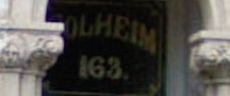

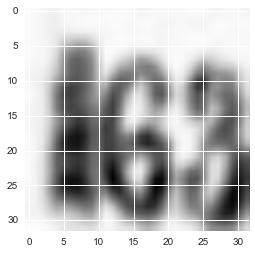

Label [3 1 6 3] - Prediction [3 1 6 2]


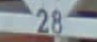

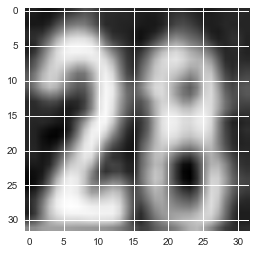

Label [2 2 8] - Prediction [2 2 8]


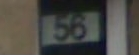

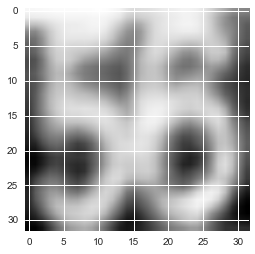

Label [2 5 6] - Prediction [2 5 6]


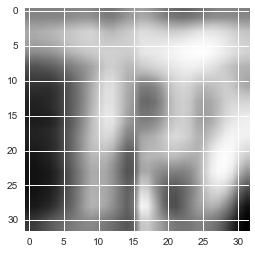

Label [2 1 9] - Prediction [2 1 7]


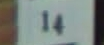

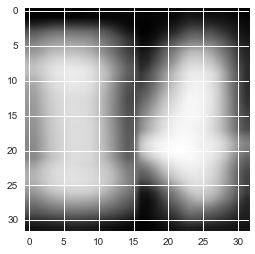

Label [2 1 4] - Prediction [2 1 4]


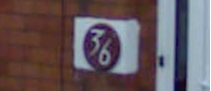

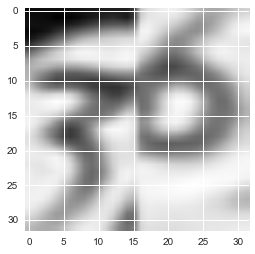

Label [2 3 6] - Prediction [2 5 9]


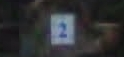

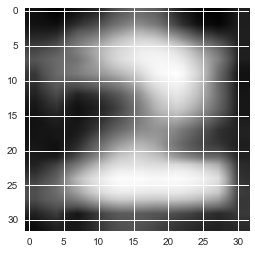

Label [1 2] - Prediction [1 2]


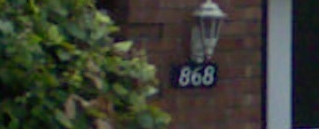

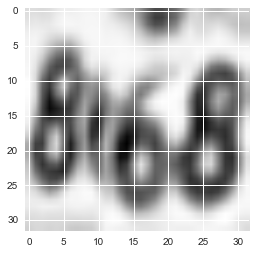

Label [3 8 6 8] - Prediction [3 3 6 8]


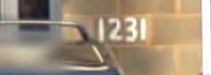

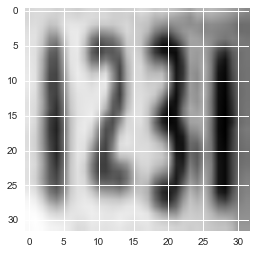

Label [4 1 2 3 1] - Prediction [4 1 2 3 1]


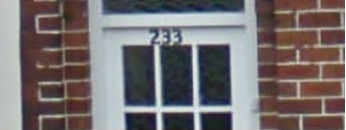

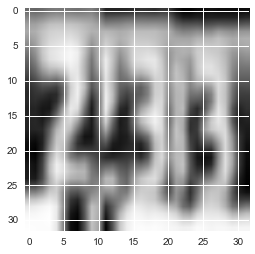

Label [3 2 3 3] - Prediction [3 2 9 3]


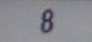

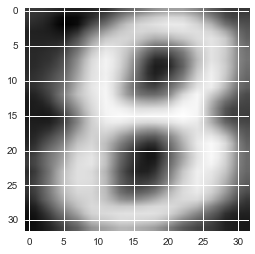

Label [1 8] - Prediction [1 8]
Validation accuracy: 96.9%


In [18]:

N = 5
IMAGE_SIZE = 32
NUM_CHANNELS = 1

SAMPLE_PRED_SIZE = 64
RTP_FOLDER = '../data/SVHN_data/test/'

def rtp_data_processing(folder):
  print('Processing %s' % folder)
  images = glob.glob(folder+'*.png')
  length = len(images)

  dataset = np.ndarray([SAMPLE_PRED_SIZE,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS], dtype='float32')
  labels = np.ndarray([SAMPLE_PRED_SIZE, N+1], dtype=int) 
  
  print('Getting Metadata')
  all_metadata = get_metadata(folder+'digitStruct.mat')
  
  print('Processing Images and Labels')
  images = glob.glob(folder+'*.png')
  images = np.random.choice(images, SAMPLE_PRED_SIZE)
  
  for img_index, image in enumerate(images):
    sr = os.path.splitext(image)[0]
    sr = sr.split('/')
    sr1 = sr[len(sr)-1]
    i = int(sr1)-1
    metadata = {}
    metadata['label'] = np.array(all_metadata['label'][i]).astype(int)
    metadata['height'] = np.array(all_metadata['height'][i]).astype(int)
    metadata['width'] = np.array(all_metadata['width'][i]).astype(int)
    metadata['top'] = np.array(all_metadata['top'][i]).astype(int)
    metadata['left'] = np.array(all_metadata['left'][i]).astype(int)
    L = len(metadata['label'])
    if L <= N:
      sequence = image_processing(image, metadata)
      seq_labels = label_processing(metadata)
      dataset[img_index] = sequence
      labels[img_index] = seq_labels

  return images, dataset, labels

initial_images, pred_dataset, pred_labels = rtp_data_processing(RTP_FOLDER)
pred_labels = label_zero(pred_labels)
print('Images Processed')


SAMPLES = 64

IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
HIDDEN_NODES = 256

graph = tf.Graph()

with graph.as_default():
  
  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(SAMPLES, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_valid_dataset = tf.constant(valid_dataset)

  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  NL_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_L = tf.nn.bias_add(tf.matmul(reshape, NL_weights), NL_biases)
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_L, feature_1, feature_2, feature_3, feature_4, feature_5  
    
  predictions = tf.pack([
                      tf.nn.softmax(model(tf_test_dataset)[0]),\
                      tf.nn.softmax(model(tf_test_dataset)[1]),\
                      tf.nn.softmax(model(tf_test_dataset)[2]),\
                      tf.nn.softmax(model(tf_test_dataset)[3]),\
                      tf.nn.softmax(model(tf_test_dataset)[4]),\
                      tf.nn.softmax(model(tf_test_dataset)[5])])
  
  test_predictions = tf.transpose(tf.argmax(predictions, 2))
  
  valid_predictions = tf.pack([
                      tf.nn.softmax(model(tf_valid_dataset)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset)[4]),\
                      tf.nn.softmax(model(tf_valid_dataset)[5])])
  
  saver = tf.train.Saver()    
  
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "../tmp/model-gcp-200k.ckpt")
  print('Model Restored')
  print('Initialized')
  test_samples = pred_dataset
  test_samples_labels = pred_labels
  test_predictions, valid_predictions = session.run([test_predictions, valid_predictions],
                                                     feed_dict={tf_test_dataset : test_samples})
  check_rtp_predictions(test_samples, test_samples_labels, test_predictions, initial_images)
  print('Validation accuracy: %.1f%%' % accuracy(valid_predictions, valid_labels))
